In [ ]:
import os
import pandas as pd
from tools import process_run_csv  # Ensure this function handles CSV processing.

# Parameters
run_start = 0
run_end   = 100
base_directory = "/work/users/k/b/kbhimani/cpu_net_g4sims/data_ornl/"
base_filename  = "data_run_{}.csv"
offset         = 1_000_001   # to ensure unique event IDs across runs
default_time   = 14_000_000  # fallback Time value if not present

# define your energy windows and the “type” names
energy_ranges = {
    (2614, 2615): "fep_wf",
    (2103, 2104): "sep_wf",
    (1592, 1593): "dep_wf"
}

# per-type limits (you can tweak these)
max_per_type = {
    "fep_wf": 100_000,
    "sep_wf": 15_000,
    "dep_wf": 10_000
}

# Output directory and file
output_dir  = "/nas/longleaf/home/kbhimani/ornl_sims/ssd_input"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "all_events.csv")

# Prepare header for tools::wcsv::ntuple
header_lines = [
    "#class tools::wcsv::ntuple",
    "#title Energy and time",
    "#separator 44",
    "#vector_separator 59",
    "#column double Event#",
    "#column double Detector_ID",
    "#column double Time",
    "#column double EnergyDeposit",
    "#column double X",
    "#column double Y",
    "#column double Z"
]

# keep counters
type_counts = {t: 0 for t in max_per_type}
global_event_id = 1  # <-- start here

with open(output_file, 'w') as out_f:
    # write header
    for line in header_lines:
        out_f.write(line + "\n")

    # loop over runs
    for run_number in range(run_start, run_end):
        print(f"Processing run {run_number}...")
        infile = os.path.join(base_directory, base_filename.format(run_number))
        run_df = process_run_csv(infile, run_number, offset)

        # for each energy window
        for (emin, emax), etype in energy_ranges.items():
            # if we've already hit the cap for this type, skip it
            if type_counts[etype] >= max_per_type[etype]:
                continue

            # filter events in that window
            filtered = run_df[(run_df['e_total'] >= emin) & (run_df['e_total'] <= emax)]
            if filtered.empty:
                continue

            # group by event
            for original_event_id, ev_hits in filtered.groupby('event'):
                if type_counts[etype] >= max_per_type[etype]:
                    break

                # write out all hits for this event using our new global_event_id
                for _, row in ev_hits.iterrows():
                    det    = int(row['detID'])
                    time   = default_time
                    energy = row['edep']
                    x      = row['x_hit']
                    y      = row['y_hit']
                    z      = row['z_hit']
                    out_f.write(f"{global_event_id},{det},{time},{energy:.17f},{x:.17f},{y:.17f},{z:.17f}\n")

                # increment both counters
                type_counts[etype]   += 1
                global_event_id      += 1

        # if *all* types are done, stop early
        if all(type_counts[t] >= max_per_type[t] for t in max_per_type):
            break

# summary
print("Done.")
for t, count in type_counts.items():
    print(f"  {t}: wrote {count} events (limit {max_per_type[t]})")
print(f"Total unique events written: {global_event_id-1}")


Processing run 0...
Processing run 1...
Processing run 2...
Processing run 3...
Processing run 4...
Processing run 5...
Processing run 6...
Processing run 7...
Processing run 8...
Processing run 9...
Processing run 10...
Processing run 11...
Processing run 12...
Processing run 13...
Processing run 14...
Processing run 15...
Processing run 16...
Processing run 17...
Processing run 18...
Processing run 19...
Processing run 20...
Processing run 21...
Processing run 22...
Processing run 23...
Processing run 24...
Processing run 25...
Processing run 26...
Processing run 27...
Processing run 28...
Processing run 29...
Processing run 30...
Processing run 31...
Processing run 32...
Processing run 33...
Processing run 34...
Processing run 35...
Processing run 36...
Processing run 37...
Processing run 38...
Processing run 39...
Processing run 40...
Processing run 41...


2975881


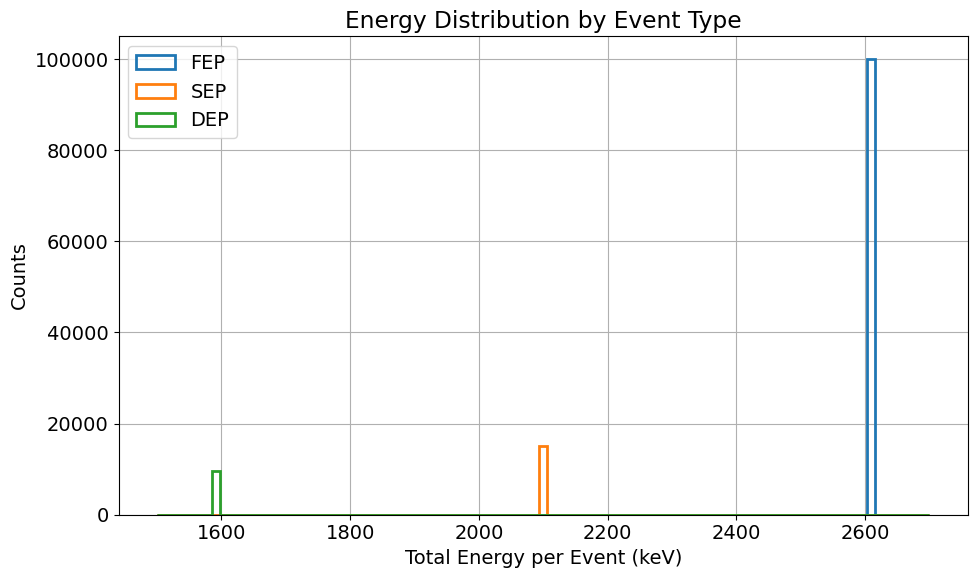

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Read the CSV (skipping comment lines)
csv_path = "/nas/longleaf/home/kbhimani/ornl_sims/ssd_input/all_events.csv"
df = pd.read_csv(csv_path, comment='#',
                 names=["Event#", "Detector_ID", "Time", "EnergyDeposit", "X", "Y", "Z"])

print(len(df))
# 2) Compute total energy per event
event_totals = df.groupby("Event#")["EnergyDeposit"].sum().reset_index()

# 3) Define your windows
energy_windows = {
    "FEP": (2614, 2615),
    "SEP": (2103, 2104),
    "DEP": (1592, 1593)
}

# 4) Classify
event_totals["Type"] = "Other"
for label, (emin, emax) in energy_windows.items():
    mask = event_totals["EnergyDeposit"].between(emin, emax)
    event_totals.loc[mask, "Type"] = label

# 5) Plot histograms
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["font.size"] = 14

bins = np.linspace(1500, 2700, 100)
for label in ["FEP", "SEP", "DEP"]:
    vals = event_totals.loc[event_totals["Type"]==label, "EnergyDeposit"]
    plt.hist(vals, bins=bins, histtype="step", linewidth=2, label=label)

plt.xlabel("Total Energy per Event (keV)")
plt.ylabel("Counts")
plt.title("Energy Distribution by Event Type")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
file_input= 'test_Kevin_V06649A_pss_truth_waveforms_adjusted_impurities_minimum_cluster.hdf5'

In [4]:
import h5py

def print_structure(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Dataset):
        print(f"{indent}{name.split('/')[-1]} (Dataset) — shape={obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{indent}{name.split('/')[-1]} (Group)")

with h5py.File(file_input, "r") as f:
    print_structure("", f)
    f.visititems(print_structure)


 (Group)
pss (Group)
  pss (Group)
    channel (Dataset) — shape=(98050,), dtype=int64
    ievt (Dataset) — shape=(98050,), dtype=int32
    waveform (Group)
      dt (Dataset) — shape=(98050,), dtype=float64
      t0 (Dataset) — shape=(98050,), dtype=float64
      values (Group)
        cumulative_length (Dataset) — shape=(98050,), dtype=int64
        flattened_data (Dataset) — shape=(16530540,), dtype=float64
  truth (Group)
    channel (Dataset) — shape=(98050,), dtype=int64
    ievt (Dataset) — shape=(98050,), dtype=int32
    waveform (Group)
      dt (Dataset) — shape=(98050,), dtype=float64
      t0 (Dataset) — shape=(98050,), dtype=float64
      values (Group)
        cumulative_length (Dataset) — shape=(98050,), dtype=int64
        flattened_data (Dataset) — shape=(16530540,), dtype=float64


In [5]:
import os
import pickle
import h5py
import numpy as np
from tqdm import tqdm

# Parameters
h5_path       = file_input
pad_width     = 500  # samples to pad on each side
pickle_outdir = "/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl"
os.makedirs(pickle_outdir, exist_ok=True)

# Energy‐range definitions (in keV)
energy_ranges = {
    (2612, 2617): "fep_wf",
    (2103, 2106): "sep_wf",
    (1592, 1595): "dep_wf"
}

# 1) Read, pad & classify
classified = {label: [] for label in energy_ranges.values()}
classified["other"] = []

with h5py.File(h5_path, "r") as f:
    wf_flat = f["pss/pss/waveform/values/flattened_data"][:]
    wf_cum  = f["pss/pss/waveform/values/cumulative_length"][:]
    t0_arr  = f["pss/pss/waveform/t0"][:]
    ievt    = f["pss/pss/ievt"][:]
    n_events = len(ievt)

    for i in tqdm(range(n_events), desc="Loading & padding"):
        start = wf_cum[i]
        end   = wf_cum[i+1] if i+1 < n_events else len(wf_flat)
        wf    = wf_flat[start:end]
        if wf.size == 0:
            continue

        padded = np.pad(wf, (pad_width, pad_width), mode="edge").astype(np.float32)
        peak = padded.max() / 1000.0

        for (emin, emax), label in energy_ranges.items():
            if emin <= peak <= emax:
                classified[label].append({
                    "wf": padded,
                    "event_index": int(ievt[i]),
                    "t0": float(t0_arr[i]),
                    "energy": peak  # or compute differently
                })
                break
        else:
            classified["other"].append({
                "wf": padded,
                "event_index": int(ievt[i]),
                "t0": float(t0_arr[i]),
                "energy": peak
            })

# 2) Write each class out exactly like your file‐based loop
for label, ev_list in classified.items():
    pickle_path = os.path.join(pickle_outdir, f"{label}_ssd_sim.pickle")
    with open(pickle_path, 'wb') as f:
        for ev in tqdm(ev_list, desc=f"Saving {label}"):
            # Here you can compute tp0 if you like:
            # ev['tp0'] = calculate_tn(ev['wf'], 99)
            event_dict = {
                "tp0": ev.get("tp0", 0),
                "wf": ev["wf"],
                "event": ev["event_index"],
                "energy": ev["energy"],
            }
            pickle.dump(event_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Completed saving {len(ev_list)} events to {pickle_path}")


Saving fep_wf: 100%|██████████| 80127/80127 [00:01<00:00, 65249.18it/s]


Completed saving 80127 events to /nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/fep_wf_ssd_sim.pickle


Saving sep_wf: 100%|██████████| 7659/7659 [00:00<00:00, 59111.34it/s]


Completed saving 7659 events to /nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/sep_wf_ssd_sim.pickle


Saving dep_wf: 100%|██████████| 4541/4541 [00:00<00:00, 57980.06it/s]


Completed saving 4541 events to /nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/dep_wf_ssd_sim.pickle


Saving other: 100%|██████████| 5722/5722 [00:00<00:00, 59552.28it/s]

Completed saving 5722 events to /nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/other_ssd_sim.pickle


Event #23: t0=0.0
  waveform length = 1172 samples
2617.4626


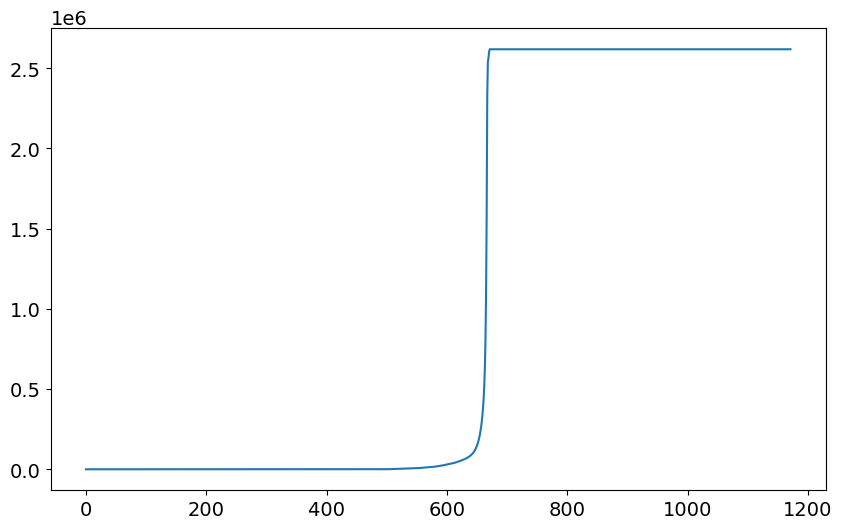

In [9]:
import matplotlib.pyplot as plt

# Example: print info for the first event
ev = ev_list[0]
print(f"Event #{ev['event_index']}: t0={ev['t0']}")
print(f"  waveform length = {len(ev['wf'])} samples")
# print(f"  total truth energy = {ev['edep_total']} keV")
plt.plot(ev['wf'])
print(max(ev['wf']/1000))

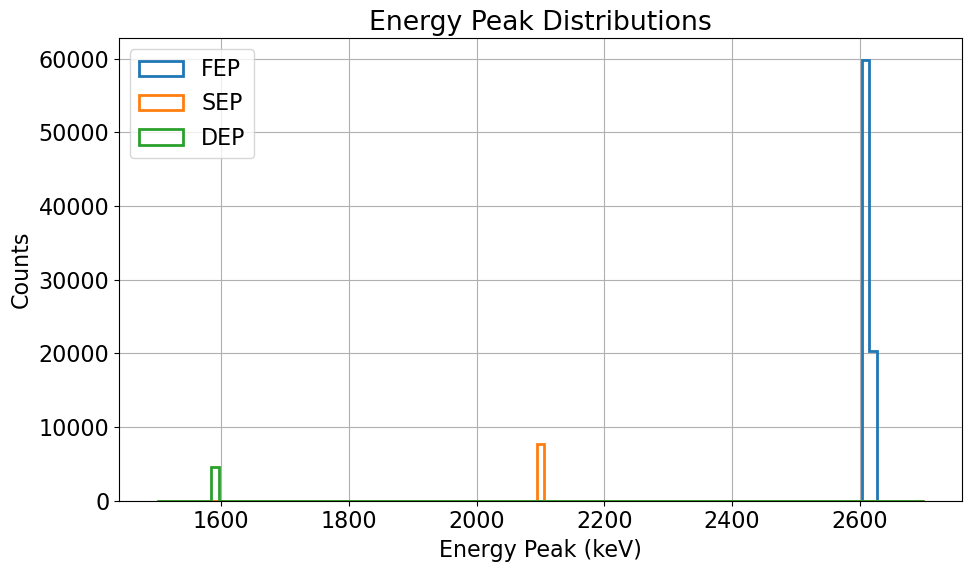

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Adjust this to your pickle output location
pickle_dir = "/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl"

# Pickle filenames and how you want to label them
classes = {
    "fep": "fep_wf_ssd_sim.pickle",
    "sep": "sep_wf_ssd_sim.pickle",
    "dep": "dep_wf_ssd_sim.pickle"
}

def load_peaks(pickle_path):
    """Load the 'energy' field from each event dict in a pickle stream."""
    peaks = []
    with open(pickle_path, 'rb') as f:
        while True:
            try:
                ev = pickle.load(f, encoding='latin1')
                peaks.append(ev['energy'])
            except EOFError:
                break
    return np.array(peaks)

# Load
data = {}
for label, fname in classes.items():
    path = f"{pickle_dir}/{fname}"
    data[label] = load_peaks(path)

# Plot
plt.rcParams['font.size'] = 16
plt.rcParams["figure.figsize"] = (10, 6)

bins = np.linspace(1500, 2700, 100)  # adjust to cover your ranges

for label, peaks in data.items():
    plt.hist(peaks, bins=bins, histtype='step', linewidth=2, label=label.upper())

plt.xlabel("Energy Peak (keV)")
plt.ylabel("Counts")
plt.title("Energy Peak Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from dspeed.processors import avg_current, upsampler, moving_window_multi, min_max
def calc_current_amplitude(waveform, plot=False):
    """
    Process a waveform through the specified DSP chain, with optional plotting.
    
    Parameters:
    waveform : numpy.ndarray
        The waveform to process.
    plot : bool
        Whether to plot the intermediate steps.
    
    Returns:
    A_max : float
        The maximum amplitude of the current waveform after processing.
    """
    waveform = waveform
    if plot:
        plt.figure(figsize=(14, 10))  # Increased figure size
        
        plt.subplot(5, 1, 1)  # Added subplot for initial waveform
        plt.plot(waveform)
        plt.title("Initial Waveform", fontsize=14)

    # Step 1: Calculate the current waveform
    current = np.zeros(len(waveform) - 1)
    avg_current(waveform, 1, current)
    
    # Plot the current waveform
    if plot:
        plt.subplot(5, 1, 2)
        plt.plot(current)
        plt.title("Step 1: Current Waveform", fontsize=14)
    
    # Step 2: Upsample the current waveform
    upsample_factor = 16
    upsampled_current = np.zeros((len(current) - 1) * upsample_factor)
    upsampler(current, upsample_factor, upsampled_current)
    
    # Plot the upsampled current waveform
    if plot:
        plt.subplot(5, 1, 3)
        plt.plot(upsampled_current)
        plt.title("Step 2: Upsampled Current Waveform", fontsize=14)
    
    # Step 3: Apply moving window to the upsampled current
    window_length = 48
    num_mw = 3
    mw_type = 0  # Alternate moving windows right and left
    smoothed_current = np.zeros_like(upsampled_current)
    moving_window_multi(upsampled_current, window_length, num_mw, mw_type, smoothed_current)
    
    # Plot the smoothed current waveform
    if plot:
        plt.subplot(5, 1, 4)
        plt.plot(smoothed_current)
        plt.title("Step 3: Smoothed Current Waveform", fontsize=14)
    
    # Step 4: Find A-Max in the smoothed current waveform
    t_min, t_max, A_min, A_max = np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)
    min_max(smoothed_current, t_min, t_max, A_min, A_max)
    
    # Plot the final waveform highlighting A-Max
    if plot:
        plt.subplot(5, 1, 5)
        plt.plot(smoothed_current)
        plt.scatter(t_max, A_max, color='red', label="A-Max")
        plt.title("Step 4: Smoothed Current Waveform with A-Max", fontsize=14)
        plt.legend(fontsize=14)
        plt.tight_layout()  # Adjust layout to make sure everything fits
        plt.savefig('figs/curr_amp_calc.pdf')
        plt.show()
    
    return A_max[0]

def normalize_sim_waveform(wf):
    """Normalize waveform to have values between 0 and 1."""
    min_val = np.min(wf)
    max_val = np.max(wf)
    if max_val > min_val:
        return (wf - min_val) / (max_val - min_val)
    else:
        # Handle the case where max_val equals min_val (e.g., constant waveforms)
        return np.zeros_like(wf)  # or wf * 0 to return a waveform of zeros

In [12]:
sample_rate= 16 # out frequency, for Flashcam it is 16 ns
eng_peak = 'sep'
eng_peak_load = 'fep'
home_dir='/nas/longleaf/home/kbhimani/'
save_dir = "/work/users/k/b/kbhimani/CPU-Net"
det_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_wf_ornl.pickle'
sim_pulses=f'/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/{eng_peak}_wf_ssd_sim.pickle'  

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Paths to your two pickle streams
sim_pulses_ssd = f'/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/{eng_peak}_wf_ssd_sim.pickle'
sim_pulses_siggen   = f'{home_dir}/CPU-Net/training_data/{eng_peak}_wf_sim.pickle'

def load_waveforms(pickle_path, max_events=None):
    """Load all waveforms from a pickle stream into a list."""
    wfs = []
    with open(pickle_path, 'rb') as f:
        while True:
            try:
                d = pickle.load(f, encoding='latin1')
                wf = d.get("wf")
                if wf is not None:
                    wfs.append(normalize_sim_waveform(wf))
                    if max_events and len(wfs) >= max_events:
                        break
            except EOFError:
                break
    return wfs

# Load a few thousand from each for speed (or omit max_events to load all)
siggen_wfs = load_waveforms(sim_pulses_siggen, max_events=5000)
ssd_wfs    = load_waveforms(sim_pulses_ssd,    max_events=5000)

# Compute current amplitudes
siggen_currents = [calc_current_amplitude(wf) for wf in siggen_wfs]
ssd_currents    = [calc_current_amplitude(wf) for wf in ssd_wfs]



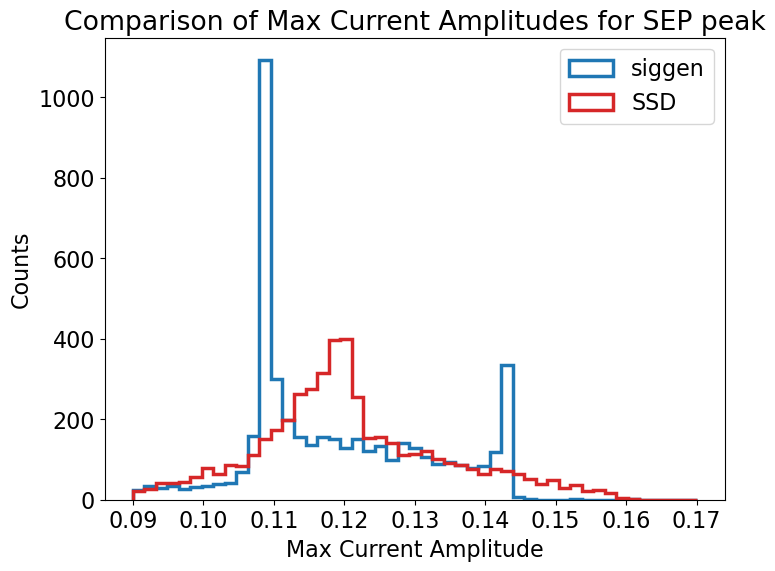

In [14]:
# sim_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_valid_transfromed.pkl'
# plt.hist(data_ca, label="Detector Peak", bins=rg, )  # Blue
# plt.hist(gan_ca, label="REN Translated Peak", bins=rg, alpha=0.3, color="#ff7f0e")  # Orange
# plt.hist(sim_ca, label="Simulated Peak", bins=rg, histtype="step", linewidth=2.5, color="tab:red") 

rg = np.linspace(0.09, 0.17, 50)

# Plot comparison
plt.figure(figsize=(8,6))
plt.hist(siggen_currents, bins=rg, histtype="step", linewidth=2.5, color="#1f77b4", label="siggen")
plt.hist(ssd_currents,    bins=rg, histtype="step", linewidth=2.5, color="tab:red", label="SSD")
plt.xlabel("Max Current Amplitude")
plt.ylabel("Counts")
plt.legend()
plt.title(f"Comparison of Max Current Amplitudes for {eng_peak.upper()} peak")
plt.savefig(f"figs/{eng_peak.upper()}_comp_ssd_sig_amp.pdf")

plt.show()
